In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#Declare a Base using 'automap_base()'
Base = automap_base()

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
#This will show you how many tables there are and then how many maps there will be
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

To begin, use Python and SQLAlchemy to do basic climate analysis and data exploration of your climate database.

# Precipitation Analysis

In [11]:
#Create the inspector and connect to engine
inspector = inspect(engine)

In [12]:
#Review names of the tables
inspector.get_table_names()

['measurement', 'station']

In [13]:
#Review column names of 'measurement' table using inspector
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
#Review column names of 'station' table using inspector
columns2 = inspector.get_columns('station')
for column in columns2:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
#Determine total dates present
session.query(func.count(Measurement.date)).all()

[(19550)]

In [16]:
#Determine latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
month_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23')\
    .filter(Measurement.date <= '2017-08-23').all()

In [18]:
#load the query into a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(month_prcp).set_index('date')

#Drop any NAN values
df_clean = df.dropna()

#Sort DataFrame values by date
df_sort = df_clean.sort_values(['date'])

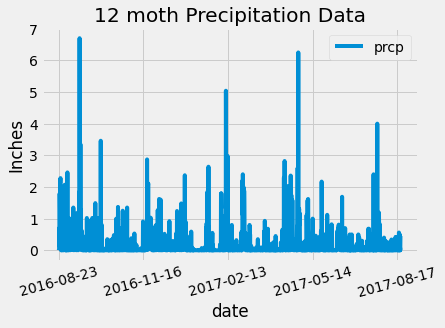

In [19]:
# Plot the results using the DataFrame plot method.
df_sort.plot(rot=15)
plt.ylabel('Inches')
plt.title('12 moth Precipitation Data')
plt.savefig('Images/PPTAnalysis.png')

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
rename = df_sort.rename(columns={'prcp':'precipitation'})
sum_stats = rename.describe()
sum_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [21]:
#Display station information from Station
dict_format = session.query(Station).first()
dict_format.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2057e5a9a60>,
 'elevation': 3.0,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

In [22]:
#Display station information from Measurement
dict_format2 = session.query(Measurement).first()
dict_format2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2057e812490>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [23]:
# Design a query to show how many stations are available in this dataset.
stations = session.query(Station.station).count()
print(f'Total number of stations is: {stations}')

Total number of stations is: 9


In [24]:
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
#Which station has the highest number of observations?
most_active = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).limit(1).all()

print(f'Station with highest number of observations:{most_active}')

Station with highest number of observations:[('USC00519281', 2772)]


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_id = session.query(func.min(Measurement.tobs), 
                           func.max(Measurement.tobs), 
                           func.avg(Measurement.tobs), 
                           func.count(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()

print(f'Min, Max, Average, Count recorded at station USC00519281: {station_id}')

Min, Max, Average, Count recorded at station USC00519281: [(54.0, 85.0, 71.66378066378067, 2772)]


In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= '2016-08-23')\
    .filter(Measurement.date <= '2017-08-23')\
    .filter(Measurement.station == 'USC00519281').all()

df_hist = pd.DataFrame(tobs).set_index('date')
# df_hist

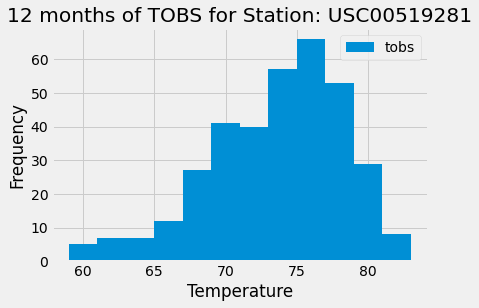

In [28]:
df_hist.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.title('12 months of TOBS for Station: USC00519281')
plt.savefig('Images/TOBS.png')